## Project: Build a Traffic Sign Classifier

The goal of this project is to design and implement a deep learning model that learns to recognize traffic signs. 
Network is trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
    
Starter code can be found at [https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project).


---
### Setting Up

#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, sys
from scipy import misc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load the Dataset

In [2]:
# Load pickled data.
import pickle

data_dir = 'traffic-signs-data/'
training_file = data_dir + 'train.p'
validation_file = data_dir + 'valid.p'
testing_file = data_dir + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---
### Dataset Summary

The pickled data is a dictionary with 4 key/value pairs:
- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates (from the original image) of a bounding box around the sign in the (original) image. 


In [3]:
# Number of training examples
n_train = np.shape(y_train)[0]

# Number of validation examples
n_valid = np.shape(y_valid)[0]

# Number of testing examples
n_test = np.shape(y_test)[0]

# Shape of a traffic sign image
image_shape = np.shape(X_train)[1:]

# Number of unique classes/labels in the dataset
n_classes = np.shape(np.unique(y_train))[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


---
### Exploratory Visualizations of the Dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

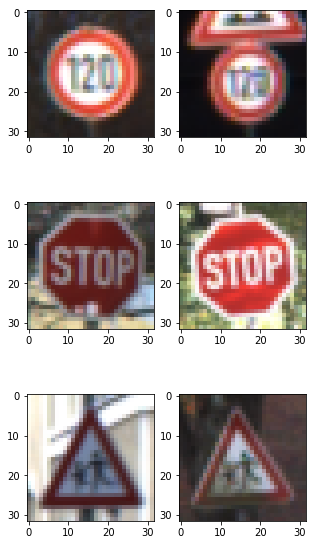

In [4]:
## Visualization of actual images from various classes.
pylab.rcParams['figure.figsize'] = (5, 10)

f, axarr = plt.subplots(3, 2)

# ClassId 8: Speed limit (120km/h)
img_indices = np.where(y_train == 8)[0]
axarr[0,0].imshow(X_train[img_indices[80]])
axarr[0,1].imshow(X_train[img_indices[640]])

# ClassId 14: Stop
img_indices = np.where(y_train == 14)[0]
axarr[1,0].imshow(X_train[img_indices[80]])
axarr[1,1].imshow(X_train[img_indices[200]])

# ClassId 28: Children crossing
img_indices = np.where(y_train == 28)[0]
axarr[2,0].imshow(X_train[img_indices[80]])
axarr[2,1].imshow(X_train[img_indices[170]])


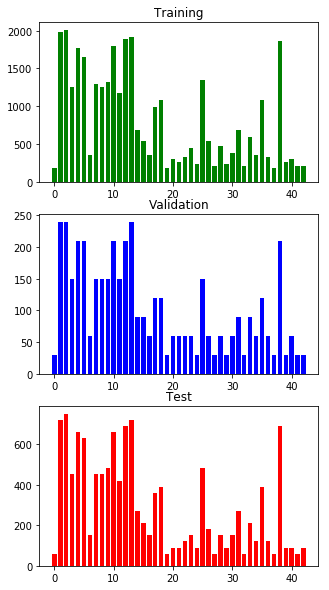

In [5]:
## Plotting the the number of images from each class.

width = 0.75       # the width of the bars
fig, ax = plt.subplots(3, 1)

# Training set
categories, counts = np.unique(y_train, return_counts=True)
ax[0].bar(categories, counts, width, color='g')
ax[0].set_title('Training')

# Validation set
categories, counts = np.unique(y_valid, return_counts=True)
ax[1].bar(categories, counts, width, color='b')
ax[1].set_title('Validation')


# Test set
categories, counts = np.unique(y_test, return_counts=True)
ax[2].bar(categories, counts, width, color='r')
ax[2].set_title('Test')


### Dataset Preprocessing

In [6]:
# Convert images to grayscale.
# Luma coding, https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems
def rgb2gray(rgb_img_mat):
    dims = np.shape(rgb_img_mat)
    return np.dot(rgb_img_mat[...,:3], [0.299, 0.587, 0.114]).reshape(dims[0], dims[1], dims[2], 1)

X_train = rgb2gray(X_train)
X_valid = rgb2gray(X_valid)
X_test = rgb2gray(X_test)

In [7]:
# Normalize data to have zero mean and equal covariance.
# `(pixel - 128)/ 128` is a quick way to approximately normalize the data.
X_train = (X_train - 128) / 128
X_valid = (X_valid - 128) / 128
X_test = (X_test - 128) / 128

In [8]:
# Shuffle data to prevent ordering of examples from affecting training.
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [9]:
# Other data preprocessing techniques that were tried, but were not used.
''' 
# Convert images to YUV
def rgb2yuv(rgb_img_mat):
    trans = np.array([[ 0.299     ,  0.587     ,  0.114      ],
                     [-0.14714119, -0.28886916,  0.43601035 ],
                     [ 0.61497538, -0.51496512, -0.10001026 ]])
    return np.dot(rgb_img_mat[...,:3], trans)

X_train = rgb2yuv(X_train)
X_valid = rgb2yuv(X_valid)
X_test = rgb2yuv(X_test)
'''

'''
# Convert images to YUV, and use only the Y
def rgb2y(rgb_img_mat):
    dims = np.shape(rgb_img_mat)
    trans = np.array([[ 0.299     ,  0.587     ,  0.114      ],
                     [-0.14714119, -0.28886916,  0.43601035 ],
                     [ 0.61497538, -0.51496512, -0.10001026 ]])
    return np.dot(rgb_img_mat[...,:3], trans)[..., 0].reshape(dims[0], dims[1], dims[2], 1)

X_train = rgb2y(X_train)
X_valid = rgb2y(X_valid)
X_test = rgb2y(X_test)
'''
np.shape(X_train)

(34799, 32, 32, 1)

---
### Model Architecture, Training Pipeline, and Evaluation

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

#### Hyperparameters

In [10]:
# Epoch count
EPOCHS = 20

# Batch size
BATCH_SIZE = 128

# Learning rate
LEARN_RATE = 0.001

# Dropout keep rate
KEEP_PROB = 0.5

#### Model Architecture
Based of of LeNet-5 and modified.

In [11]:
from tensorflow.contrib.layers import flatten, xavier_initializer

def nnet(x):    
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    #mu = 0
    #sigma = 0.1
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        ## Layer 1 ##

        # Convolutional. Input = 32x32x1. Output = 28x28x6.
        conv1_W = tf.Variable(initializer((5, 5, 1, 6)))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # Activation.
        conv1 = tf.nn.relu(conv1)

        # Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten. Input = 14x14x6. Output = 1176.
        # This output bypasses Layer2 and is used as part of the first fully connected layer (Layer 3)
        fc0_l1 = flatten(conv1)



        ## Layer 2 ##

        # Convolutional. Input = 14x14x6. Output = 10x10x16.
        conv2_W = tf.Variable(initializer((5, 5, 6, 16)))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # Activation.
        conv2 = tf.nn.relu(conv2)

        # Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten. Input = 5x5x16. Output = 400.
        fc0_l2 = flatten(conv2)

        # Concatenate both flattened conv layers to create a fully connected layer.
        # Idea inspired from http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
        # Note that in tensorflow 0.12.1, the first argument to concat is the axis, unlike the new versions.
        fc0 = tf.concat(1, [fc0_l1, fc0_l2])


        ## Layer 3 ##

        # Fully Connected. Input = 1576. Output = 400.
        fc1_W = tf.Variable(initializer((1576, 400)))
        fc1_b = tf.Variable(tf.zeros(400))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # Activation.
        fc1    = tf.nn.relu(fc1)

        # Dropout.
        fc1 = tf.nn.dropout(fc1, keep_prob)


        ## Layer 4 ##

        # Fully Connected. Input = 400. Output = 120.
        fc2_W = tf.Variable(initializer((400, 120)))
        fc2_b  = tf.Variable(tf.zeros(120))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        
        # Activation.
        fc2    = tf.nn.relu(fc2)

        ## Mod - Dropout
        fc2 = tf.nn.dropout(fc2, keep_prob)

        

        ## Layer 5 ##

        # Fully Connected. Input = 120. Output = 84.
        fc3_W = tf.Variable(initializer((120, 84)))
        fc3_b  = tf.Variable(tf.zeros(84))
        fc3    = tf.matmul(fc2, fc3_W) + fc3_b

        # Activation.
        fc3    = tf.nn.relu(fc3)

        ## Mod - Dropout
        fc3 = tf.nn.dropout(fc3, keep_prob)

        

        ## Layer 6 ##

        # Fully Connected. Input = 84. Output = 43.
        fc4_W = tf.Variable(initializer((84, 43)))
        fc4_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc3, fc4_W) + fc4_b

    return logits

In [12]:
# Placeholders for a batch of input images and output labels, respectively.
# Labels are converted into one-hot representations.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)

#### Training Pipeline

In [13]:
# Logits - unnormalized log probabilities, output of the network
logits = nnet(x)  

# Cross entropy quantifies accuracy of prediction against truth.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Minimize the mean of cross entropy with Adam algorithm.
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [14]:
# Define 'correct' as that prediction and label are equal.
# Accuracy is obtained by taking the average number of correct predictions.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

---
### Model Training

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        # Shuffle training at the beginning of each epoch.
        X_train, y_train = shuffle(X_train, y_train)
        
        # Rub training data through train pipeline in batches.
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        # At the end of each epoch, measure loss and accuracy on the validation set.
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the model.
    saver.save(sess, './nnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.536

EPOCH 2 ...
Validation Accuracy = 0.797

EPOCH 3 ...
Validation Accuracy = 0.830

EPOCH 4 ...
Validation Accuracy = 0.868

EPOCH 5 ...
Validation Accuracy = 0.878

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.930

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.941

EPOCH 11 ...
Validation Accuracy = 0.938

EPOCH 12 ...
Validation Accuracy = 0.949

EPOCH 13 ...
Validation Accuracy = 0.949

EPOCH 14 ...
Validation Accuracy = 0.945

EPOCH 15 ...
Validation Accuracy = 0.949

EPOCH 16 ...
Validation Accuracy = 0.951

EPOCH 17 ...
Validation Accuracy = 0.948

EPOCH 18 ...
Validation Accuracy = 0.959

EPOCH 19 ...
Validation Accuracy = 0.949

EPOCH 20 ...
Validation Accuracy = 0.953

Model saved


---
### Evaluating Model on Test Set

Only do this once the model is finalized.

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.933


---
### Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

#### Load and Output the Images

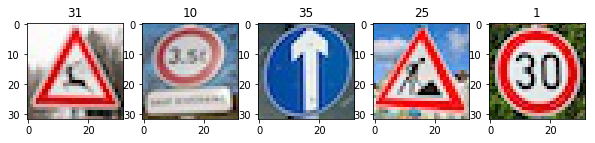

In [17]:
## Loads and plots new images.
## These images were create outside of the notebook as follows:
##  - Download photo images containing traffic signs.
##  - Crop out the region of interest containg the sign.
##  - Resize the cropped image into 32x32.
##  - Save the resized image as JPG
pylab.rcParams['figure.figsize'] = (10, 10)

X_online_imgs = np.zeros((5, 32, 32, 3), dtype='float32')
y_online_labels = np.zeros((5,))

path = './online_imgs/'
imgfiles = os.listdir(path)

f, axarr = plt.subplots(1, 5)
i = 0
for imgfile in imgfiles:
    if os.path.isfile(path + imgfile):
        
        im = misc.imread(path+imgfile, mode='RGB')
        category, ext = os.path.splitext(imgfile)        
        X_online_imgs[i] = np.array(im)
        y_online_labels[i] = int(category)
        axarr[i].imshow(im)
        axarr[i].set_title(category)
        i += 1


In [18]:
# Grayscale new images (rgb -> gray)
X_online_imgs = np.float32(rgb2gray(X_online_imgs))

#### Predict on New Images

In [19]:
## Print categories predicted by the model for given X_data.
def get_predictions(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
    return predictions

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = get_predictions(X_online_imgs, y_online_labels)
    print('Predictions: %s' % str(predictions))
    print('Actual:         %s' % str(np.int32(y_online_labels)))
    

Predictions: [31 28 35 25  1]
Actual:         [31 10 35 25  1]


#### Calculate Accuracy

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_online_imgs, y_online_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.800


---
### Output Top 5 Softmax Probabilities for New Images

In [21]:
## Top five softmax probabilities and categories for the predictions on the images found on the web. 

def get_top_k_predictions(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        top_k_softmax_probs, top_k_softmax_cats  = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5, sorted=True), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
    return top_k_softmax_probs, top_k_softmax_cats

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_probs, top_k_cats = get_top_k_predictions(X_online_imgs, y_online_labels)
    
    for i in range (0, 5):
        tkp, tkc, actual = top_k_probs[i], top_k_cats[i], y_online_labels[i]
        print("Image %s: " % str(i+1))
        print("Top K softmax probabilities: %s" % str(tkp))
        print("Top K categories: %s" % str(tkc))
        print("Actual category: %d\n" % int(actual))
    

Image 1: 
Top K softmax probabilities: [ 1.  0.  0.  0.  0.]
Top K categories: [31  0  1  2  3]
Actual category: 31

Image 2: 
Top K softmax probabilities: [  1.00000000e+00   3.02058016e-24   4.81119606e-30   3.44094563e-34
   1.44641079e-34]
Top K categories: [28 41 20 24 36]
Actual category: 10

Image 3: 
Top K softmax probabilities: [ 1.  0.  0.  0.  0.]
Top K categories: [35  0  1  2  3]
Actual category: 35

Image 4: 
Top K softmax probabilities: [ 1.  0.  0.  0.  0.]
Top K categories: [25  0  1  2  3]
Actual category: 25

Image 5: 
Top K softmax probabilities: [ 1.  0.  0.  0.  0.]
Top K categories: [1 0 2 3 4]
Actual category: 1



---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")